### 説明変数選択の続き

In [ ]:
#reasonなしの方がAICが小さかったので、こちらを採用。

In [ ]:
#Cell_26.
from statsmodels.stats.outliers_influence import variance_inflation_factor
num_cols = mod2.exog.shape[1] 
vifs = [variance_inflation_factor(mod2.exog, i)
        for i in range(0, num_cols)]
pd.DataFrame(vifs, index=mod2.exog_names, columns=["VIF"])

In [ ]:
#すべて10未満のため、多重共線性(マルチコ)は検出されなかった。

In [ ]:
#Cell_27.
#標準化する前のデータフレームで重回帰分析。これが最終モデル。
X_final = X_dumm[['failures', 'higher', 'schoolsup', 'studytime', 'health', 'goout', 'age', 'absences']]

mod_final = sm.OLS(y, sm.add_constant(X_final))
res_final = mod_final.fit()
print(res_final.summary())

In [ ]:
#以下では、最終モデルについて、信頼区間、予測区間を算出。

In [ ]:
#Cell_28.
#Variance-covariance matrix.
Sigma = np.asmatrix(X_final.cov())

In [ ]:
#Cell_29.
def Mahala2(vec_x, vec_mean, mat):
    length = mat.shape[0]
    vec_x = np.array(vec_x, dtype='float64')
    vec = np.asmatrix((vec_x - vec_mean).values.reshape(length, 1))
    inv = np.linalg.inv(mat)
    mahala2 = vec.T.dot(inv.dot(vec))
    return mahala2[0, 0]

In [ ]:
#Cell_30.
import scipy.stats as ss
n = len(X_final) # 標本数. Sample size.
dfm = res_final.df_model # 独立変数の数（モデルの自由度）．　Number of IVs (Model degrees of freedom). 
t_0025 = ss.t.isf(q=0.05/2, df=n-dfm-1) # 自由度 n-dfm-1のt分布の上側2.5パーセント点(= ss.t.ppf(q=0.975, df=n-dfm-1))
vec_mean = X_final.mean() # 独立変数の平均を求める　Find average of independent variables
print(vec_mean)

In [ ]:
#Cell_31.
display(X_final.head())

In [ ]:
#Cell_32.
#観測値に対応する従属変数の信頼区間を求める Find CI of Y on observed values
X = sm.add_constant(X_final).iloc[0,:] 
print(X)
hat_y=X.dot(res_final.params) # Xとresults.paramsの内積を求め従属変数の推定値を求める　Obtain estimated value of dependent variable
print(hat_y)

D2_0 = Mahala2(X_final.iloc[0,:], vec_mean, Sigma) # マハラノビス距離の二乗を求める Squared Mahalanobis distance

Ve = res_final.scale #  残差変動の不偏分散． A scale factor for the covariance matrix.
Se_o = np.sqrt((1/n + D2_0 / (n-1)) * Ve) #観測値の場合　In case of observed value

ci_low = hat_y - t_0025 * Se_o# 下側信頼
ci_up = hat_y + t_0025 * Se_o # 上側信頼

print("理論値（theoretical value）:", hat_y)
print("理論値の信頼区間（CI of theoretical value）：({0},{1})".format(ci_low,ci_up))

In [ ]:
#Cell_33.
#予測値（未観測値に対応する従属変数）の信頼区間を求める Find prediction interval of Y on unobserved values
X_test2 = X_test[['failures', 'higher', 'schoolsup', 'studytime', 'health', 'goout', 'age', 'absences']] #未観測値の設定
X = sm.add_constant(X_test2).iloc[0,:]
#print(X)
hat_y=X.dot(res_final.params) # Xとresults.paramsの内積を求め従属変数の推定値を求める　Obtain estimated value of dependent variable

D2_0 = Mahala2(X_test2.iloc[0,:], vec_mean, Sigma) # マハラノビス距離の二乗を求める Squared Mahalanobis distance
Se_p = np.sqrt((1 + 1/n + D2_0 / (n-1)) * Ve) #未観測値の場合　In case of unobserved value

pi_low = hat_y - t_0025 * Se_p# 下側信頼
pi_up = hat_y + t_0025 * Se_p # 上側信頼

print("予測値（Predicted value）:", hat_y)
print("予測値の信頼区間（CI of predicted value）：({0},{1})".format(pi_low,pi_up))

In [ ]:
#Cell_34.
x_axis = np.linspace(0, 30, 2000) 

#従属変数の予測値が入る変数
hat_y = []
#age以外は、平均値で固定
(a1,a2,a3,a4,a5,a6,a7)=vec_mean[['failures','higher','schoolsup','studytime','health','goout','absences']]

for x in x_axis:
    X = np.array([1,a1,a2,a3,a4,a5,a6,x,a7])
    hat_y.append(X.dot(res_final.params))# Xとresults.paramsの内積を求め従属変数の推定値を求める Obtain estimated value of dependent variable
plt.plot(x_axis, hat_y, label="Predicted value") # 予測値をプロット

D2 = []
for x in x_axis:
    D2_0 = Mahala2([a1,a2,a3,a4,a5,a6,x,a7], vec_mean, Sigma) # マハラノビス距離の二乗を求める Squared Mahalanobis distance
    D2.append(D2_0)
D2 = np.array(D2)

Se_o = np.sqrt((1/n + D2 / (n-1)) * Ve) #観測値の場合　In case of observation value
Se_p = np.sqrt((1 + 1/n + D2 / (n-1)) * Ve) #未観測値の場合　In case of unobserved value

# 観測値に対応する従属変数の信頼区間をプロット
plt.plot(x_axis, hat_y - t_0025 * Se_o, "--g", label="95% theoritical confidence interval")
plt.plot(x_axis, hat_y + t_0025 * Se_o, "--g")

# 予測値の信頼区間をプロット
plt.plot(x_axis, hat_y - t_0025 * Se_p, "--r", label="95% prediction interval")
plt.plot(x_axis, hat_y + t_0025 * Se_p, "--r")

plt.xlabel("Age")
plt.ylabel("G3")
plt.legend()
plt.show()

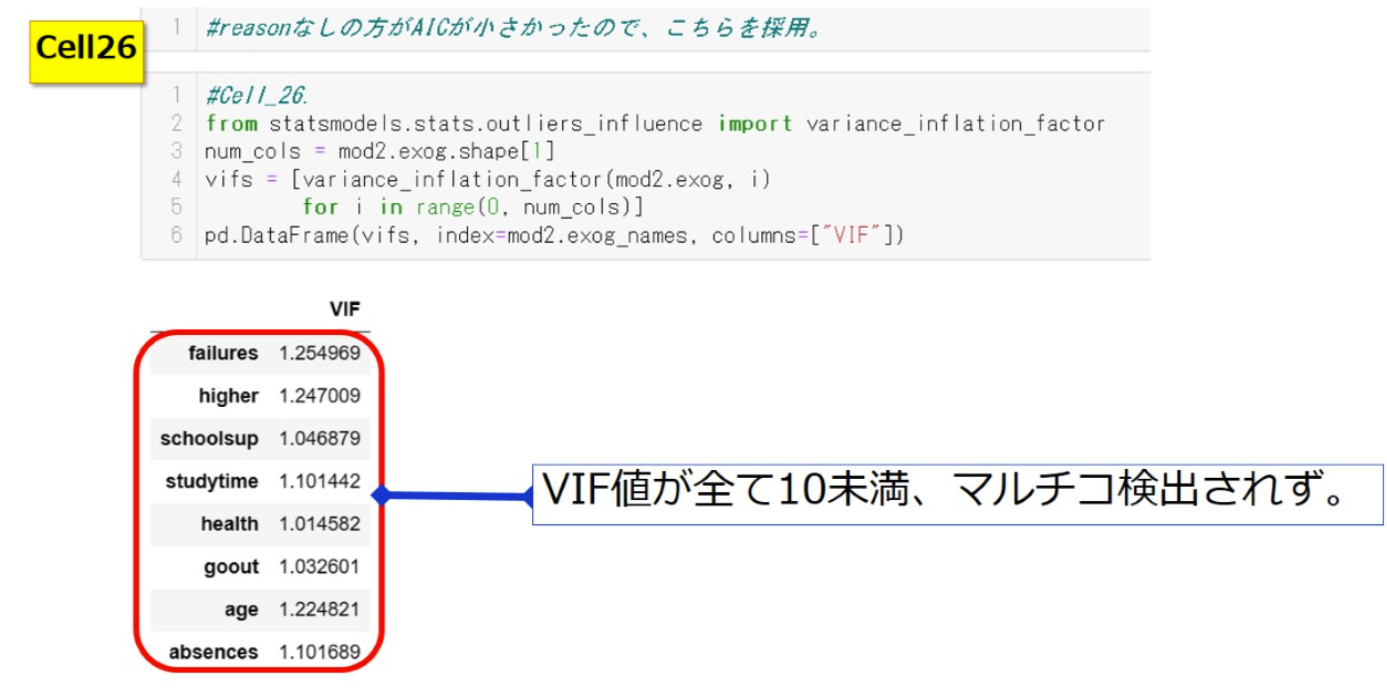
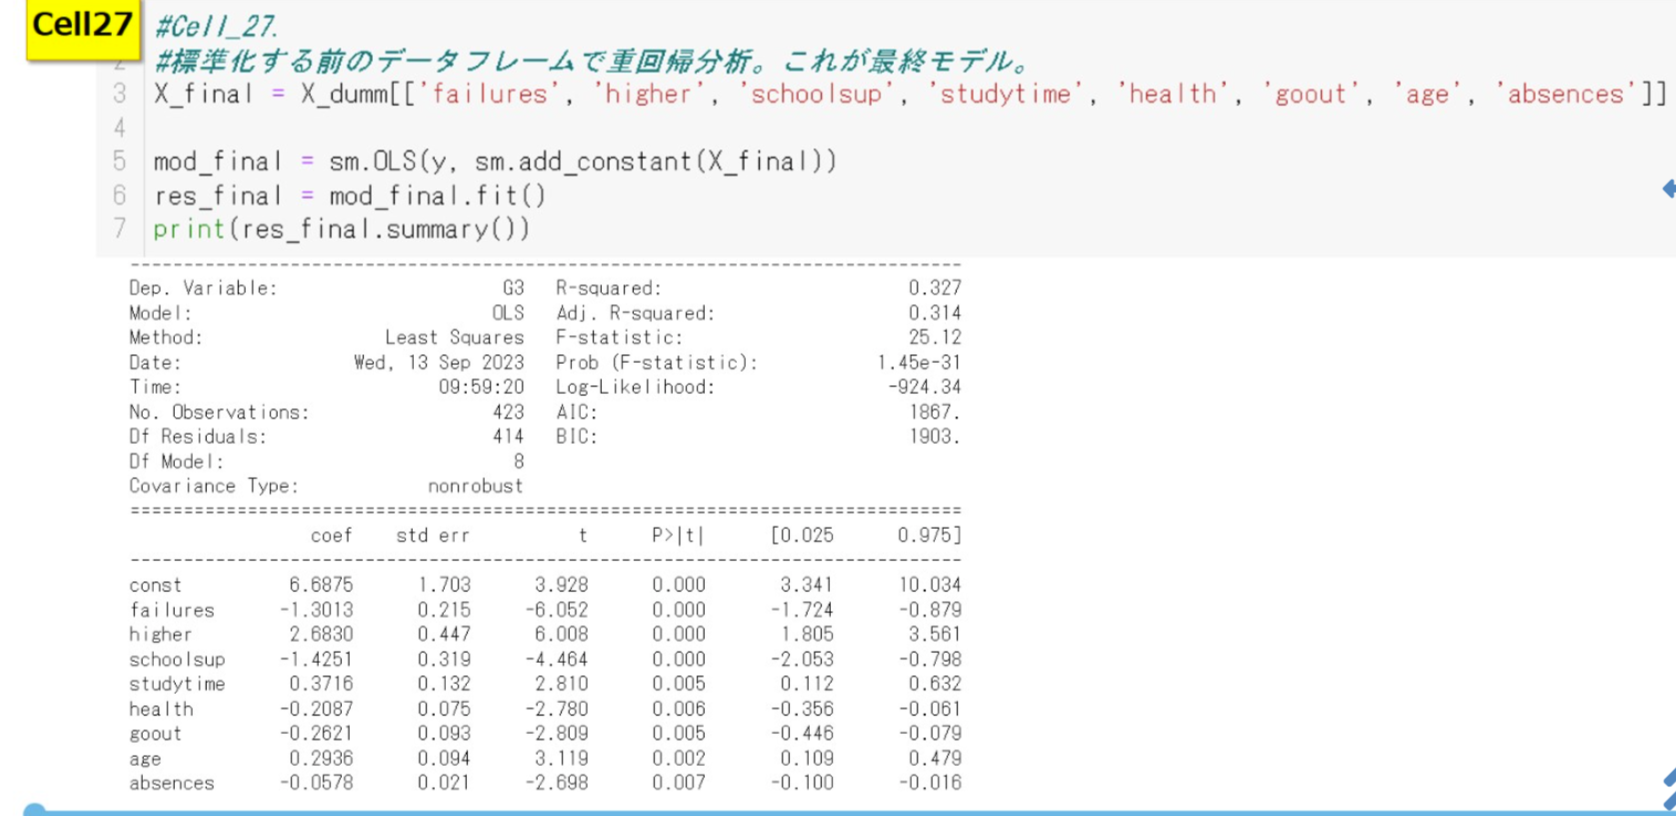
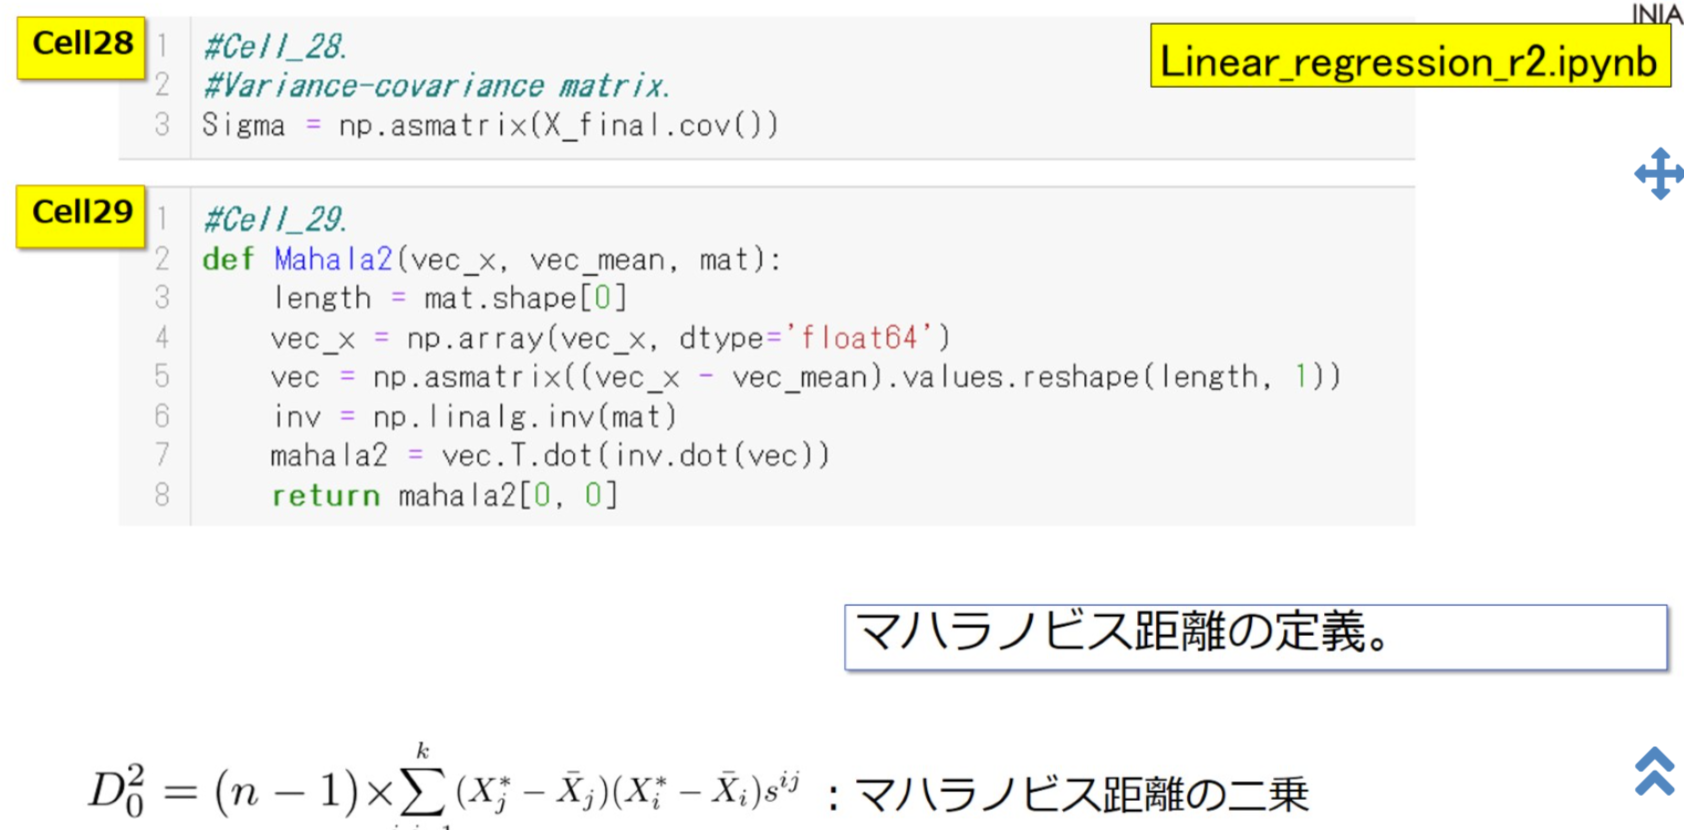
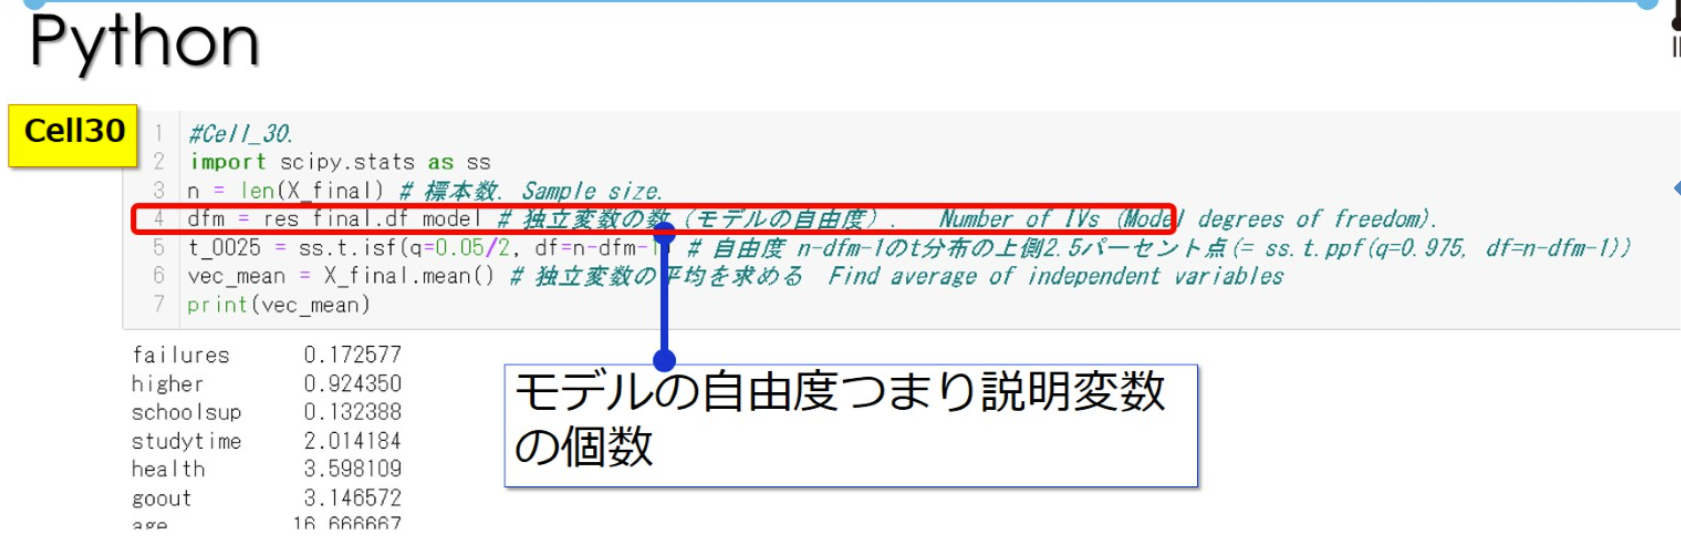